Deniz Gülal

## Web Scraping
Here, I start to fetch quotes data from the website using web scraping techniques. The process involves accessing web pages, extracting relevant information such as author names, quote content, and associated tags, and organizing this data into a structured format for better analysis.

When I was searching on Google I saw this [link](https://bhavyasree.github.io/PythonClass/Notebooks/18.scrape-quotes/) which helped me a lot while I code the snippet below. I modified the code according our needs. The core of the process is a while that iterates over each page of the website, scraping quotes data until no more quotes are found. Within this loop, retrieve HTML content, and parse it using BeautifulSoup to extract relevant information. Additionally, we maintain a dictionary (content_dict) to map quote content to its corresponding author name and tags.





In [2]:
import requests
import pandas as pd
import bs4
import numpy as np
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import os
from collections import defaultdict
import tqdm.notebook as tq

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
data_dir = "/content/drive/MyDrive"

In [3]:
page_valid = True
page = 1
authors = set()
tags_set = set()
base_url = 'http://quotes.toscrape.com/page/'
df = pd.DataFrame()
author_list = []
content = []
tags_2nd = []
content_dict = {}
while page_valid:
    scrape_url = base_url + str(page)
    result = requests.get(scrape_url)

    if 'No quotes found!' in result.text:
        break

    soup = bs4.BeautifulSoup(result.text,'lxml')

    for author_tag in soup.select('.author'):
        author_name = author_tag.get_text(strip=True)
        authors.add(author_name)
        author_list.append(author_name)

    for text in soup.select('.text'):
        content.append(text.text)

    for tag_container in soup.select('.tags'):
        tags_1st = []
        for tag_link in tag_container.select('a.tag'):
            tag = tag_link.text.strip()
            tags_set.add(tag)
            tags_1st.append(tag)
        tags_2nd.append(tags_1st)

    for count in range(len(content)):

        content_dict.update({content[count]: (author_list[count], tags_2nd[count])})


    page +=1

## Tag Encoding

In this section, the goal is to convert the categorical tag information into a binary format that is suitable for machine learning algorithms. This process involves creating a binary array for each tag list, where each element represents the presence or absence of a particular tag. We begin initializing an empty list label_2nd, which will store the binary arrays corresponding to each tag list.

Next, we check if the set of unique tags (tags_set) is not empty. If there are tags present, we proceed with the label encoding process.

We convert the set of tags into a numpy array (tag_array) to facilitate indexing operations. This array serves as a reference for mapping tags to their corresponding indices.

For each tag list (tag_list) in tags_2nd, we initialize a binary array (label_1st) of zeros with a length equal to the total number of unique tags. This array will represent the presence or absence of each tag in the tag list.

We iterate through each tag in the tag list and check if it exists in the tag_array. If the tag is found, we find its index in the array and set the corresponding element in label_1st to 1, indicating the tag exists.

After processing all tags in a tag list, we append the resulting binary array (label_1st) to the label_2nd list.

Finally, we obtain the label encoding for all tag lists in the label_2nd list, representing the presence or absence of each unique tag for every quote.


In [4]:
label_2nd = []


if tags_set:
    tag_array = np.array(list(tags_set))  # Convert set to list before converting to array

    for tag_list in tags_2nd:
        label_1st = [0] * len(tags_set)  # Initialize label array for each tag list


        for tag in tag_list:
            if tag in tag_array:  # Check if the tag is in the tag array
                index = np.where(tag_array == tag)[0][0]  # Find the index of the tag in the array
                label_1st[index] = 1  # Set the corresponding element in label array to 1


        label_2nd.append(label_1st)


#label_2nd

## Datafame Creation

we create a DataFrame df to organize the scraped data and perform keyword encoding for multi-label classification. We initialize the DataFrame df with four columns:

writer: Contains the names of the authors.
text: Stores the quotes text.
keywords: Stores the list of tags associated with each quote.
label: Represents the label encoding for the tags using binary arrays.

For each unique keyword in the tags_set, we create a new binary column in the  df. These columns will represent the presence or absence of each keyword in the keywords list. We iterate over each unique keyword in tags_set and check if it exists in the keywords list for each row. If the keyword is present, we assign a value of 1 to the corresponding binary column; otherwise, we assign 0. We add the binary columns for each keyword to the df, encoding the keywords for multi-label classification. By performing keyword encoding, we transform the categorical tag information into a format suitable for training machine learning models, enabling tasks such as multi-label classification based on the presence of specific keywords in quotes.

In [5]:
df = pd.DataFrame({
    'writer': author_list,
    'text': content,
    'keywords': tags_2nd,
    'label' : label_2nd

})
for keyword in tags_set:
    df[keyword] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)

for keyword in tags_set:
    # Check if the keyword is in the list of keywords for each row
    df[keyword] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)

df

<ipython-input-5-7cd970cafec4>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[keyword] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)
<ipython-input-5-7cd970cafec4>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[keyword] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)
<ipython-input-5-7cd970cafec4>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

,writer,text,keywords,label,inspiration,planning,sinister,wander,age,miracle,...,books,misattributed-to-einstein,drug,open-mind,miracles,good,abilities,philosophy,life,unhappy-marriage
0,Albert Einstein,“The world as we have created it is a process ...,"[change, deep-thoughts, thinking, world]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,J.K. Rowling,"“It is our choices, Harry, that show what we t...","[abilities, choices]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Albert Einstein,“There are only two ways to live your life. On...,"[inspirational, life, live, miracle, miracles]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,Jane Austen,"“The person, be it gentleman or lady, who has ...","[aliteracy, books, classic, humor]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Marilyn Monroe,"“Imperfection is beauty, madness is genius and...","[be-yourself, inspirational]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Harper Lee,“You never really understand a person until yo...,[better-life-empathy],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,Madeleine L'Engle,“You have to write the book that wants to be w...,"[books, children, difficult, grown-ups, write,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
97,Mark Twain,“Never tell the truth to people who are not wo...,[truth],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,Dr. Seuss,"“A person's a person, no matter how small.”",[inspirational],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tokenization

In [6]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


## Hyperparameter Tuning Using the Weights & Biases (wandb) Platform
Firstly, the wandb library is imported, which serves as a powerful tool for experiment tracking and visualization, essential for managing hyperparameter search and model training.

Next, a sweep configuration is defined, outlining the strategy for exploring different combinations of hyperparameters. This configuration includes:

The "method" parameter determines the way for exploring the hyperparameter space. Here, it's set to "random", that the search will randomly sample hyperparameter values. The metric parameter specifies the key metric to optimize during the search. In this case, the focus is on maximizing the validation accuracy ('val_accuracy'). Under the parameters section, the hyperparameters to be tuned are listed along with the values they can take.

Three hyperparameters are included:

learning_rate: A range of learning rates to experiment with.
batch_size: Different batch sizes to try during training.
epochs: Various numbers of epochs to train the model.
Additionally, default values for these hyperparameters are provided in the sweep_defaults dictionary.

Once the configuration is defined, the wandb.sweep() function is invoked with the sweep configuration as an argument. This action creates a new sweep in the Weights & Biases dashboard, laying the groundwork for conducting hyperparameter search experiments.

Finally, the sweep_id variable captures the unique identifier assigned to the newly created sweep. This ID serves as a reference point for executing and managing the sweep in subsequent stages of the hyperparameter tuning process.

In [7]:
import wandb
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs':{
            'values':[2, 3, 4]
        }
    }
}
sweep_defaults = {
            'learning_rate': 5e-5,

        'batch_size': 32,

        'epochs':2
}

sweep_id = wandb.sweep(sweep_config)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 59


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: zgm49m2j
Sweep URL: https://wandb.ai/dgulal20/uncategorized/sweeps/zgm49m2j


## Splitting Dataset
Splitting the dataset into training, validation, and test sets using the train_test_split function from the scikit-learn library.

Parameters:

  random_state=77: This sets the random seed to ensure reproducibility. Specifying the same seed ensures that the data split remains consistent across different runs.
  test_size=0.30: This parameter determines the proportion of the dataset to allocate for the test set. Here, 30% of the data is reserved for testing.
  shuffle=True: Setting this parameter to True shuffles the data before splitting, which helps in removing any inherent ordering in the dataset.

The function returns two sets: df_train containing the training data and df_test containing the test data.

In [8]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df, random_state=88, test_size=0.50, shuffle=True)

In [9]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (70, 141), Test: (50, 141), Valid: (50, 141)


## Hyperparameters

**MAX_LEN:** It specifies the maximum length of the input sequences. It is set to 256, meaning that input sequences longer than 256 tokens will be truncated, and sequences shorter than 256 tokens will be padded to match this length. Controlling the maximum length of sequences helps **manage computational resources during training**.

**TRAIN_BATCH_SIZE:** It determines the batch size used during training. Batch size refers to the number of samples processed in one forward/backward pass. Here, it is set to 16, meaning that the model will process 16 samples at a time during training. Beforehand it was 32, which yielded a memory error. Then I went with 16.

**VALID_BATCH_SIZE:** It sets the batch size for the validation dataset. It is also set to 16, ensuring consistent batch sizes across training and validation phases.

**TEST_BATCH_SIZE:** Similar to the previous two parameters, TEST_BATCH_SIZE specifies the batch size for the test dataset. Again, it is set to 16 for consistency.

**EPOCHS:** An epoch represents one complete pass through the entire training dataset. It determines the number of times the model will iterate over the entire dataset during training. Here, it is set to 10, showing that the model will undergo 10 complete training cycles.

**LEARNING_RATE:** Learning rate controls the step size taken during optimization to update the model parameters. A lower learning rate **leads to slower convergence but can help prevent overshooting the optimal solution**.

**THRESHOLD:** It specifies the threshold value used for the sigmoid activation function. During prediction, the output of the model's sigmoid activation function is compared to this threshold to determine the final binary classification output. If the sigmoid output is greater than the threshold, the prediction is considered positive; otherwise, it is considered negative. Here, it is set to 0.5, indicating that predictions with sigmoid output greater than 0.5 will be classified as positive.

In [10]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

## BERT Implementation
In this project, I chose to use BERT for processing quotes. Some of the reasons why I decided on BERT are:

**Semantic Understanding**

**Contextualized Representations**

**Handling Polysemy and Ambiguity**

**Multi-Label Classification**

BERT is a state-of-the-art NLP model that has been pre-trained on a large corpus of text data. It has a strong capability in understanding the semantic meaning of words, sentences, and documents. Quotes often contain complex and nuanced meanings, and BERT's bidirectional context understanding helps capture these subtleties effectively. BERT generates contextualized word representations by considering the entire input sentence. This means that each word's representation is influenced by the context of the entire quote. In quotes with multiple tags, the context of each tag and its relationship with other words in the quote are crucial for accurate understanding. Also, quotes may contain words with multiple meanings (polysemy) or ambiguous phrases. BERT's contextual embeddings enable it to disambiguate such words based on their context within the quote. This is particularly useful when dealing with tags that have multiple interpretations or when tags appear in ambiguous contexts within quotes.

I chose to focus on finding the most important tag. But to find the multiple tags, the task typically involves multi-label classification, where each quote can be associated with multiple tags simultaneously. BERT can be fine-tuned for multi-label classification tasks by modifying the output layer to predict multiple labels. Moreover, BERT is pre-trained on large text corpora using unsupervised learning objectives, such as masked language modeling and next sentence prediction. This pre-training enables BERT to learn rich language representations that capture various linguistic properties.



In [11]:
from transformers import BertTokenizer, BertModel

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
df_train['text']

33    “Not all of us can do great things. But we can...
38    “I have always imagined that Paradise will be ...
66    “There is nothing to writing. All you do is si...
75    “The reason I talk to myself is because I’m th...
2     “There are only two ways to live your life. On...
                            ...                        
37     “Any fool can know. The point is to understand.”
97    “Never tell the truth to people who are not wo...
84    “There are few people whom I really love, and ...
95    “You never really understand a person until yo...
87    “The fear of death follows from the fear of li...
Name: text, Length: 70, dtype: object

## Implementation Details

During the implemantation I found this [github repo](https://github.com/dtolk/multilabel-BERT) very useful. I changed it according to our requirements but for the main flow it helped me.

For each quote in the dataset, the text is tokenized using the BERT tokenizer.
Tokenized sequences are trimmed or padded to fit the specified maximum length.
Token IDs, attention masks, and token type IDs are generated for each tokenized sequence.
Target labels are converted into a suitable format for PyTorch.

In [14]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [15]:
target_list = list(df.columns[4:])
target_list
target_list = target_list[:-1]

In [16]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [17]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

The BERTClass provides the BERT model, extending PyTorch's neural network module. Within its structure, it loads the pre-trained BERT model (bert-base-uncased) and configures it to return outputs as a dictionary. This model has dropout regularization to mitigate overfitting and includes a linear layer to adjust BERT's output dimensions to match the classification task's requirements.

During the forward pass, input token IDs, attention masks, and token type IDs are passed through the BERT model. Then, the dropout layer is applied to the pooled output, and the resulting tensor is processed through the linear layer to produce the final logits for classification.


In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 136)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

#model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
# This version is more numerically stable than using a plain Sigmoid followed
# by a BCELoss as, by combining the operations into one layer,
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [20]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


For each batch of data, the input token IDs, attention masks, and token type IDs are extracted from the data dictionary. These inputs are fed forward through the model to generate predictions, and the loss is computed using the defined loss function.

Then, the predictions are converted into probabilities using a sigmoid function, and both the predictions and ground truth targets are converted into NumPy arrays for further processing. The number of correct predictions and total samples are updated accordingly.

After the forward pass, the optimizer's gradients are reset to zero, and backpropagation is performed to compute the gradients of the loss with respect to the model parameters. To prevent exploding gradients, gradient clipping is applied. Finally, the optimizer takes a step in the direction that minimizes the loss, updating the model parameters.

The function returns the trained model, the accuracy achieved during training, and the mean loss computed across all batches.

In [21]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(dtype = torch.long)
        mask = data['attention_mask'].to( dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(dtype = torch.long)
        targets = data['targets'].to(dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()


    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

Model Evaluation

In [22]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(dtype = torch.long)
            mask = data['attention_mask'].to(dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(dtype = torch.long)
            targets = data['targets'].to(dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

These below metrics provide insights into how well the model is learning from the training data and how well it generalizes to unseen data.

The training and validation metrics are recorded in a dictionary "history", where the training accuracy, training loss, validation accuracy, and validation loss are stored for each epoch.

Additionally, the code checks if the current validation accuracy (val_acc) is higher than the best accuracy (best_accuracy) seen so far. If it is, the model's state dictionary is saved to a file named "MLTC_model_state.bin".

In [23]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"Colab Notebooks","MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6937, val_loss=0.6765 train_acc=0.5146, val_acc=0.5785
Epoch 2/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6742, val_loss=0.6597 train_acc=0.5707, val_acc=0.6169
Epoch 3/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6607, val_loss=0.6425 train_acc=0.6039, val_acc=0.6460
Epoch 4/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6451, val_loss=0.6226 train_acc=0.6340, val_acc=0.6853
Epoch 5/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6264, val_loss=0.6011 train_acc=0.6666, val_acc=0.7216
Epoch 6/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.6052, val_loss=0.5820 train_acc=0.6987, val_acc=0.7703
Epoch 7/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.5873, val_loss=0.5624 train_acc=0.7349, val_acc=0.8159
Epoch 8/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.5659, val_loss=0.5437 train_acc=0.7745, val_acc=0.8588
Epoch 9/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.5497, val_loss=0.5265 train_acc=0.8055, val_acc=0.8913
Epoch 10/10


  0%|          | 0/5 [00:00<?, ?it/s]

train_loss=0.5320, val_loss=0.5101 train_acc=0.8380, val_acc=0.9271


In [24]:
import matplotlib.pyplot as plt

## Model Performance Visualization

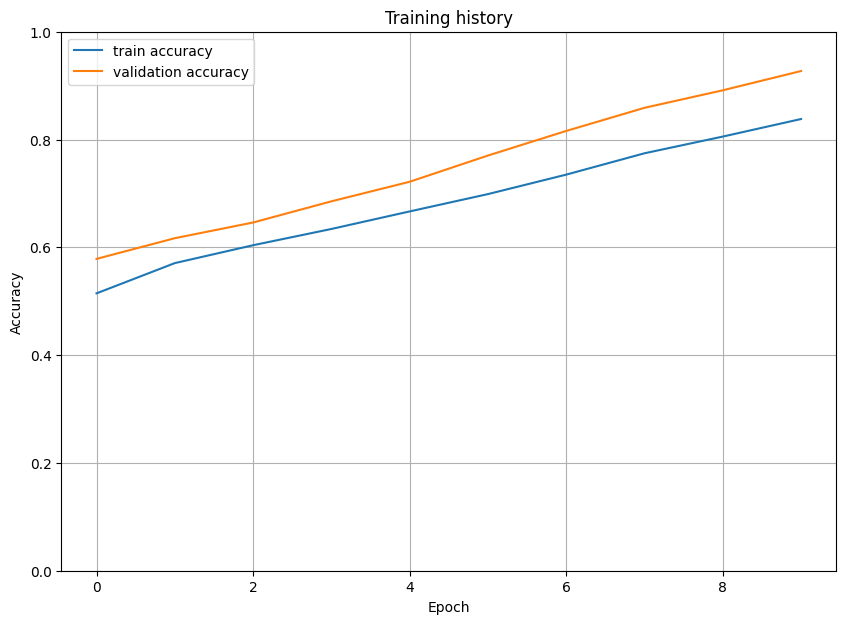

In [25]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Reload the Model for Test Dataset

In [26]:
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"Colab Notebooks","MLTC_model_state.bin")))

<All keys matched successfully>

In [27]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

The test_acc variable shows the accuracy of the trained model on the test dataset. It represents how well the model performs on unseen data that it hasn't been trained or validated on.

In this case, the model achieved an accuracy of about 92.70% on the test dataset.

In [28]:
test_acc

0.9270588235294117

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

After iterating the test dataset, for each batch, the input data is passed through the model to obtain raw output logits. These logits represent the model's confidence scores for each class or label. The sigmoid function is applied to these logits to convert them into probabilities, representing the likelihood of each label being present in the input text. After obtaining the prediction probabilities, a thresholding mechanism is applied. This involves rounding the probabilities to the nearest integer (0 or 1), effectively converting them into binary predictions.

In [30]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(dtype = torch.long)
        mask = data["attention_mask"].to(dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(dtype = torch.long)
        targets = data["targets"].to(dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [31]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [32]:
predictions.numpy()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [33]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:50 
predictions:torch.Size([50, 136]) 
prediction_probs:torch.Size([50, 136]) 
target_values:torch.Size([50, 136])


Results Overview Tags Based

In [34]:
print(classification_report(target_values, predictions, target_names=target_list))

                                 precision    recall  f1-score   support

                    inspiration       0.00      0.00      0.00         1
                       planning       0.00      0.00      0.00         0
                       sinister       0.00      0.00      0.00         1
                         wander       0.00      0.00      0.00         1
                            age       0.00      0.00      0.00         0
                        miracle       0.00      0.00      0.00         0
                           lost       0.00      0.00      0.00         1
                     heartbreak       0.00      0.00      0.00         1
                          peace       0.00      0.00      0.00         1
                      aliteracy       0.00      0.00      0.00         1
                          seuss       0.00      0.00      0.00         0
                      chocolate       0.00      0.00      0.00         0
                     literature       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
